In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

import warnings
warnings.filterwarnings('ignore')

input_path = './data/'
loan200 = pd.read_csv(input_path + 'loan200.csv')
loan_data = pd.read_csv(input_path + 'loan_data.csv.gz')

# 6 Statistical Machine Learning

## 6.1 K-Nearest Neighbors

The idea behind K-Nearest Neighbors (KNN) is very simple. For each record to be classified or predicted:
1. Find K records that have similar features (i.e., similar predictor values).
2. For classification, find out what the majority class is among those similar records and assign that class to the new record.
3. For prediction (also called KNN regression), find the average among those similar records, and predict that average for the new record.

#### <center>Key Terms for K-Nearest Neighbors</center>
- ***Neighbor***  
A record that has similar predictor values to another record.
- ***Distance metrics***  
Measures that sum up in a single number how far one record is from another.
- ***Standardization***  
Subtract the mean and divide by the standard deviation.<br>  
*Synonym*
    - Normalization
- ***z-score***  
The value that results after standardization.
- ***K***  
The number of neighbors considered in the nearest neighbor calculation.

### Example: Predicting Loan Default

In [2]:
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)

array(['paid off'], dtype=object)

### Distance Metrics

Similarity (nearness) is determined using a *distance metric*, which is a function that measures how far two records $(x_1,x_2,\cdots ,x_p)$ and $(u_1,u_2,\cdots ,u_p)$ are from one another.

**Euclidean distance**:
$$\sqrt{(x_1-u_1)^2+(x_2-u_2)^2+\cdots +(x_p-u_p)^2}$$

**Manhattan distance**:
$$|x_1-u_1|+|x_2-u_2|+\cdots +|x_p-u_p|$$

### Standardization (Normalization, z-Scores)

Standardization puts all variables on the same scale.

For KNN and a few other procedures (e.g., principal components analysis and clustering), it is essential to consider standardizing the data prior to applying the procedure.

In [3]:
# show neighbors without variable standardization
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
X.iloc[nbrs[1][0], :]

,payment_inc_ratio,dti,revol_bal,revol_util
35536,1.47212,1.46,1686,10.0
33651,3.38178,6.37,1688,8.4
25863,2.36303,1.39,1691,3.5
42953,1.28160,7.14,1684,3.9
43599,4.12244,8.98,1684,7.2


The value of `revol_bal` in these neighbors is very close to its value in the new record, but the other predictor variables are all over the map and essentially play no role in determining neighbors.

In [4]:
# show neighbors with variable standardization
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = StandardScaler()
scaler.fit(X)

X_std = scaler.transform(X)
newloan_std = scaler.transform(newloan)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
X.iloc[nbrs[1][0], :]

,payment_inc_ratio,dti,revol_bal,revol_util
2080,2.61091,1.03,1218,9.7
1438,2.34343,0.51,278,9.9
30215,2.71200,1.34,1075,8.5
28542,2.39760,0.74,2917,7.4
44737,2.34309,1.37,488,7.2


The five nearest neighbors are much more alike in all the variables, providing a more sensible result. Note that the results are displayed on the original scale, but KNN was applied to the scaled data and the new loan to be predicted.

**NOTE**  
Using the z-score is just one way to rescale variables. Instead of the mean, a more robust estimate of location could be used, such as the median. Likewise, a different estimate of scale such as the inter quartile range could be used instead of the standard deviation. Sometimes, variables are “squashed” into the 0–1 range. It’s also important to realize that scaling each variable to have unit variance is somewhat arbitrary. This implies that each variable is thought to have the same importance in predictive power. If you have subjective knowledge that some variables are more important than others, then these could be scaled up. For example, with the loan data, it is reasonable to expect that the payment-to-income ratio is very important.

### Choosing K

If *K* is too low, we may be overfitting. If *K* is too high, we may oversmooth the data and miss out on KNN's ability to capture the local structure in the data.

The *K* that best balances between overfitting and oversmoothing is typically determined by accuracy metrics and, in particular, accuracy with holdout or validation data.

### KNN as a Feature Engine

KNN gained its popularity due to its simplicity and intuitive nature. In terms of performance, KNN by itself is usually not competitive with more sophisticated classification techniques. In practical model fitting, however, KNN can be used to add “local knowledge” in a staged process with other classification techniques.

## 6.2 Tree Models

#### <center>Key Terms for Trees</center>
- ***Recursive partitioning***  
Repeatedly dividing and subdividing the data with the goal of making the outcomes in each final subdivision as homogeneous as possible.
- ***Split value***  
A predictor value that divides the records into those where that predictor is less than the split value, and those where it is more.
- ***Node***  
In the decision tree, or in the set of corresponding branching rules, a node is the graphical or rule representation of a split value.
- ***Leaf***  
The end of a set of if-then rules, or branches of a tree—the rules that bring you to that leaf provide one of the classification rules for any record in a tree.
- ***Loss***  
The number of misclassifications at a stage in the splitting process; the more losses, the more impurity.
- ***Impurity***  
The extent to which a mix of classes is found in a subpartition of the data (the more mixed, the more impure).<br>  
    - *Synonym*
        - Heterogeneity
    - *Antonyms*
        - Homogeneity, purity
- ***Pruning***  
The process of taking a fully grown tree and progressively cutting its branches back to reduce overfitting.

### Measuring Homogeneity or Impurity

$p$ is the proportion of misclassified records within a partion, which ranges from 0 (perfect) to 0.5 (purely random guessing).

**Gini impurity**: $2p(1-p)$

**Entropy**: $-p\log_2(p) - (1-p) \log_2(1-p)$

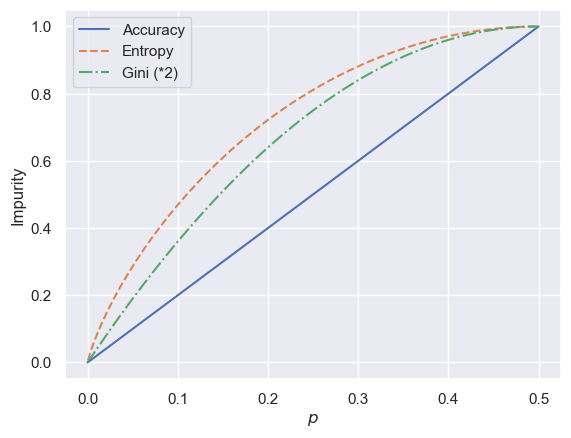

In [21]:
x = np.linspace(0, 0.5, 1000)
accuracy = 2*x
gini = 2*x*(1-x)
entropy = -x*np.log2(x)-(1-x)*np.log2(1-x)

sns.lineplot(
    x=x,
    y=accuracy,
    label='Accuracy'
)
sns.lineplot(
    x=x,
    y=entropy,
    label='Entropy',
    ls='--'
)
sns.lineplot(
    x=x,
    y=gini * 2,
    label='Gini (*2)',
    ls='-.'
)
plt.xlabel('$p$')
plt.ylabel('Impurity')
plt.show()

Above plot shows that Gini impurity (rescaled) and entropy measures are similar, with entropy giving higher impurity scores for moderate and high accuracy rates.

Gini impurity and Entropy for more than 2 classes:
$$
Gini(E)=1-\sum_{j=1}^{c} p_j^2\\
E(S)=\sum_{j=1}^{c} -p_j \log_2 p_j
$$

## 6.3 Bagging and the Random Forest

#### <center>Key Terms for Bagging and the Random Forest</center>
- ***Ensemble***  
Forming a prediction by using a collection of models.<br>  
*Synonym*
    - Model averaging
- ***Bagging***  
A general technique to form a collection of models by bootstrapping the data.<br>  
*Synonym*
    - Bootstrap aggregation
- ***Random forest***  
A type of bagged estimate based on decision tree models.<br>  
*Synonym*
    - Bagged decision trees
- ***Variable importance***  
A measure of the importance of a predictor variable in the performance of the model.

Random Forest build multiple decision tress in parallel (bagging), each using a subset records (bootstrap) and variables. These trees are ensembled to a forest to make final predictions (average of all trees) together.

## 6.3 Boosting

#### <center>Key Terms for Boosting</center>
- ***Ensemble***  
Forming a prediction by using a collection of models.<br>  
*Synonym*
    - Model averaging
- ***Boosting***  
A general technique to fit a sequence of models by giving more weight to the records with large residuals for each successive round.
- ***Adaboost***  
An early version of boosting that reweights the data based on the residuals.
- ***Gradient boosting***  
A more general form of boosting that is cast in terms of minimizing a cost function.
- ***Stochastic gradient boosting***  
The most general algorithm for boosting that incorporates resampling of records and columns in each round.
- ***Regularization***  
A technique to avoid overfitting by adding a penalty term to the cost function on the number of parameters in the model.
- ***Hyperparameters***  
Parameters that need to be set before fitting the algorithm.